# Analysis on Amazon Reviews

data from: https://nijianmo.github.io/amazon/index.html


Goal: Recommend items based on user reviews. 

TBD: add content w/ links to sections

In [3]:
import pandas as pd
import gzip
import json

In [2]:
# read in data
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

In [ ]:
# note: takes a while to import the large data set, skip to importing csv file
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Video_Games.json.gz')

In [ ]:
df.head()

In [ ]:
df_meta = getDF('meta_Video_Games.json.gz')

In [ ]:
df_meta.head()

Merge both data sets

In [ ]:
merge = df.merge(df_meta, on="asin", how='left')

In [ ]:
pd.options.display.max_columns = None
merge.tail()

In [ ]:
#Save data to csv file on hard disk 
merge.to_csv('/Users/anitatran/Desktop/amazon_review_project/video_games_reviews.csv')


## Loading data from CSV file saved (start here)

In [1]:
#Loading the data from the csv file 
import pandas as pd
df = pd.read_csv('video_games_reviews.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (10,14,20,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# # overall average of rating 
# ratings = []

# for review in parse("Video_Games.json.gz"):
#   ratings.append(review['overall'])

# print(sum(ratings) / len(ratings))

In [4]:
# selecting relevant columns 
# df_test = merge[['reviewerID','asin','reviewerName','reviewText','overall','summary','title']]

NameError: name 'merge' is not defined

In [ ]:
# drop nulls
# df =  df_test.dropna()
# df.info()

In [ ]:
print( 'Total reviews:' , len(df)  )
print( 'Number of products reviewed:' , len(df.asin.unique()) )
print('Total number of reviewers:', len(df.reviewerID.unique()) )

## Data Visualization

### Visualizing ratings distribution in the data

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns 
#Group dataframe by rating 
ratings_distribution = df[['asin','overall']] \
.groupby('overall') \
.count() \
.reset_index() \
.rename( columns = {'asin':'count'} )

#visualize distributions using a doughnut plot 
f,ax = plt.subplots( figsize = (10,10) )
names =  [ '1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars' ]
size = list( ratings_distribution['count'] )
my_circle = plt.Circle( (0,0), 0.7, color = 'white' )
plt.pie( size, labels = names, wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' }, colors=['yellow','green','orange','blue', 'red'],
       textprops={'fontsize': 14})
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
df.hist()

Looking at the charts we can see that 5 star reviews account for *most* of all reviews and 1 star reviews account for the smallest chunk. This can be interpreted as customers only review a product when they are very satisfied.

My previous connotation is most people only review a product when they are very satisfied with it. According to the data that does not seem to be the case.

## Data Cleaning & Word Embedding

In [ ]:
#Combining review text and summary columns into one column called 'review_text
df['review_text'] = df['reviewText'] + ' . ' + df['summary']
del df['reviewText']


In [ ]:
del df['summary']
df.head()

In [ ]:
# the percentage of missing data in each column
df.isnull().sum() / len(df)


In [ ]:
#importing necessary libraries 
import numpy as np
import string 
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
nltk.download('wordnet')
nltk.download('punkt')
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# saving the original df
df_original = df

In [ ]:
df_original.info()

In [ ]:
# sample 100000 randomly for easier computation here...
df = df_original.sample(100000).reset_index(drop=True)

In [ ]:
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [ ]:
%%time
#Function that lemmatizes and then stems word tokens in that order 
def lemmatizer_stemmer(word):
    return PorterStemmer().stem( WordNetLemmatizer().lemmatize(word, pos = 'v') )
#Tokenizer that calls the lemmatizer_stemmer function and removes tokens that are just punctuation 
def tokenizer(text):
    return [ lemmatizer_stemmer(word) for word in nltk.word_tokenize(text) if word not in string.punctuation and len(word) > 3 ]
#Converting pre-processed text to bag of words embedding 
vectorizer_unigram = CountVectorizer( max_features = 100, min_df = 15, max_df = 0.5 , ngram_range = (1,1), stop_words = 'english', tokenizer = tokenizer )
X_unigram_bow = vectorizer_unigram.fit_transform( df.review_text ).tocsc()

#### Looking at the 20 most commonly occuring unigrams in the text vectors

In [ ]:
freq_unigram = zip( vectorizer_unigram.get_feature_names(), np.asarray( X_unigram_bow.sum(axis = 0) ).ravel() ) 
freq_unigram_sorted = sorted( list(freq_unigram), key = lambda x: x[1] , reverse = True)
for word_tuple in freq_unigram_sorted[:20]:
    print("Feature: '{}' appeared {} times".format(word_tuple[0],word_tuple[1]) )

In [ ]:
df.head()

In [ ]:
from wordcloud import WordCloud
frequency_dict = dict(freq_unigram_sorted)
wordcloud = WordCloud(background_color = 'white')
wordcloud.generate_from_frequencies(frequencies = frequency_dict)
plt.figure(figsize = (12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Looking at the 20 most commonly occuring bi-grams in the text vectors

In [ ]:
%%time
vectorizer_bigram = CountVectorizer( max_features = 100, min_df = 15, max_df = 0.5 , ngram_range = (2,2), stop_words = 'english', tokenizer = tokenizer )
X_bigram_bow = vectorizer_bigram.fit_transform( df.review_text ).tocsc()

freq_bigram = zip( vectorizer_bigram.get_feature_names(), np.asarray( X_bigram_bow.sum(axis = 0) ).ravel() ) 
freq_bigram_sorted = sorted( list(freq_bigram), key = lambda x: x[1] , reverse = True)
for word_tuple in freq_bigram_sorted[:20]:
    print("Feature: '{}' appeared {} times".format(word_tuple[0],word_tuple[1]) )

Naive Bayes with BOW and TF-IDF Word Embeddings (Multi-Class Classification)


The gensim library has a great pre-processor that tokenizes removes punctuation, non-alphabetic characters,
extra white spaces , stopwords and stems tokens. The purpose of this section is to tokenize and pre-process
review text and fit a naive bayes classifier to see if we can build a model that can with some accuracy
predict the overall rating of a review given the text of the review. For this problem I'll use the following
combination of word embeddings with a Naive Bayes classifier.

* Unigrams w/ Bag of Words Embeddings
* Unigrams w/ Tf-idf Embeddings
* Bi-grams w/ Bag of Words Embeddings
* Bi-grams w/ Tf-idf Embeddings

In [ ]:
from gensim.parsing.preprocessing import preprocess_documents

def gensim_preprocess(text):
    return preprocess_documents( [text] )[0]

vectorizer_unigram_gensim = CountVectorizer( min_df = 15, max_df = 0.7 , ngram_range = (1,1), tokenizer = gensim_preprocess )
X_unigram_bow_gensim = vectorizer_unigram_gensim.fit_transform( df.review_text )

Following steps
- Split dataset into train and test 
- Define pipeline that transforms bag of words to tf-idf embedding 
- Fit a naive bayes classifier

In [ ]:
import warnings
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
warnings.simplefilter(action='ignore', category=FutureWarning)

X_unigram = X_unigram_bow_gensim
y = df.overall.values

X_unigram_train,X_unigram_test,y_train,y_test = train_test_split( X_unigram, y, test_size = 0.3, random_state = 42 )

#Pipeline that takes in a Bag of words embeddings (Sklearn Countvectorizer) and converts them to Tf-idf embeddings 
#and trains a Naive Bayes Classifier on them
tfidf_naiveB_pipeline = Pipeline( steps = [ ( 'tfifd', TfidfTransformer() ) , ( 'nb', MultinomialNB() ) ])

#### Unigram w/ Tf-idf Embeddings

In [ ]:
#Cross Validating to find best value for hyperparameter alpha
param_dict_nb_tfidf = dict( nb__alpha = [0.001,0.01,1.0,10] )
cv_nb_tfidf_unigram = GridSearchCV( tfidf_naiveB_pipeline, param_grid = param_dict_nb_tfidf, cv = 5, n_jobs = -1, iid = False )
cv_nb_tfidf_unigram.fit(X_unigram_train,y_train)
print('Best Parameter alpha:', cv_nb_tfidf_unigram.best_params_)
print('Best Validation Score:', cv_nb_tfidf_unigram.best_score_)

In [ ]:
test_score1 = cv_nb_tfidf_unigram.best_estimator_.score(X_unigram_test,y_test)  * 100
print('Accuracy on holdout set: {} %'.format(test_score1) )

#### Unigram w/ Bag of Words Embeddings

In [ ]:
#Cross Validating to find best value for hyperparameter alpha
nb = MultinomialNB()
param_dict_nb_countVect = dict( alpha = [0.001,0.01,1.0,10] )
cv_nb_countVect_unigram = GridSearchCV( nb, param_grid = param_dict_nb_countVect, cv = 5, n_jobs = -1, iid = False )
cv_nb_countVect_unigram.fit(X_unigram_train,y_train)
print('Best Parameter alpha:', cv_nb_countVect_unigram.best_params_)
print('Best Validation Score:', cv_nb_countVect_unigram.best_score_)

In [ ]:
test_score2 = cv_nb_countVect_unigram.best_estimator_.score(X_unigram_test,y_test)  * 100
print('Accuracy on holdout set: {} %'.format(test_score2) )

In [ ]:
vectorizer_bigram_gensim = CountVectorizer(min_df = 15, max_df = 0.7 , ngram_range = (2,2), tokenizer = gensim_preprocess )
X_bigram_bow_gensim = vectorizer_bigram_gensim.fit_transform( df.review_text )

X_bigram = X_bigram_bow_gensim
X_bigram_train, X_bigram_test, y_train, y_test = train_test_split( X_bigram, y, test_size = 0.3, random_state = 42 )

#### Bi-grams w/ Tf-idf Embeddings

In [ ]:
#Cross Validating to find best value for hyperparameter alpha
cv_nb_tfidf_bigram = GridSearchCV( tfidf_naiveB_pipeline, param_grid = param_dict_nb_tfidf, cv = 5, n_jobs = -1, iid = False )
cv_nb_tfidf_bigram.fit(X_bigram_train, y_train)
print('Best Parameter alpha:', cv_nb_tfidf_bigram.best_params_)
print('Best Validation Score:', cv_nb_tfidf_bigram.best_score_)

In [ ]:
test_score3 = cv_nb_tfidf_bigram.best_estimator_.score(X_bigram_test,y_test)  * 100
print('Accuracy on holdout set: {} %'.format(test_score3) )

#### Bi-grams w/ Bag of Words Embeddings

In [ ]:
#Cross Validating to find best value for hyperparameter alpha
cv_nb_countVect_bigram = GridSearchCV( nb, param_grid = param_dict_nb_countVect, cv = 5, n_jobs = -1, iid = False )
cv_nb_countVect_bigram.fit(X_bigram_train,y_train)
print('Best Parameter alpha:', cv_nb_countVect_bigram.best_params_)
print('Best Validation Score:', cv_nb_countVect_bigram.best_score_)

In [ ]:
test_score4 = cv_nb_countVect_bigram.best_estimator_.score(X_bigram_test,y_test)  * 100
print('Accuracy on holdout set: {} %'.format(test_score4) )

In [ ]:
naive_bayes_specs_dict = { 'Specifications':[ 'Unigram Tfidf' , 'Unigram CountVect', 'Bigram Tfidf', 'Bigram CountVect' ] ,
                         'Accuracy_Score':[ test_score1, test_score2, test_score3, test_score4 ] }
naive_bayes_specs_df = pd.DataFrame( naive_bayes_specs_dict )
naive_bayes_specs_df

With respect to our model's perfomance on unseen data, bigrams
seems to outperform unigrams for both tfidf and BOW approach, with 
tfidf and bigrams having the highest accuracy on unseen data

### Interpretible Machine Learning with Local Surrogate Models approach

The purpose of this section to take the best performing model and see what it has learned from the data <br>
and see how it explains a prediction it makes. For this purpose I will be using the <br>
LIME(Local interpretable model agnostic explanations) library which takes a trained model <br>
and fits a local surrogate model or a simpler interpretable model on the predictions of a <br>
more complicated black box model with respect to the observation of interest in order to explain <br>
why the model made the prediction it made. I will be pulling the following rated reviews <br>
that are not present in the dataset the model was trained on:<br>
* A 5-star review (Clearly Positive)
* A 1-star review (Clearly Negative)
* A 3-star review (somewhere in the middle) 
<br>

I will make predicitons using our model on each of these reviews and use a LIME explainer to visualize why our <br>
model made the prediction it made.

In [ ]:
#Importing necessary LIME classes and building a pipeline that vectorizes and makes predictions
#using our best naive bayes model
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
explainer = LimeTextExplainer( class_names = ['1.0', '2.0', '3.0', '4.0', '5.0'] )
exp_pipeline = make_pipeline( vectorizer_unigram_gensim, cv_nb_countVect_unigram.best_estimator_  )

In [ ]:
df.head()

In [ ]:
df.info()

#### Predicting the overall score for a 5-star review from an unseen product

5-star review 
Ref: https://www.amazon.ca/product-reviews/B07XV4NHHN/ref=acr_dp_hist_5?ie=UTF8&filterByStar=five_star&reviewerType=all_reviews#reviews-filter-bar

By William
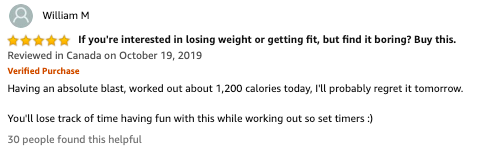

In [ ]:
test_review_5star = "Having an absolute blast, worked out about 1,200 calories today, I'll probably regret it tomorrow. You'll lose track of time having fun with this while working out so set timers :)"

print( 'Predicted rating', exp_pipeline.predict( [test_review_5star] ) )
print( 'Probabilities for all classes', exp_pipeline.predict_proba( [test_review_5star] ) )

In [ ]:
exp = explainer.explain_instance(test_review_5star, exp_pipeline.predict_proba, num_features=8, top_labels=2)
exp.show_in_notebook(text=True)

Our model made the correct prediction of score 5 <br>
* The model predicted overall rating of 5 with 91% probability becuase from the training data <br> 
it learned to associate words such as 'gifts', 'podge', 'crafts', 'year' with 5-star <br>
reviews.
* The next class with the highest probability predicted by our model is 4 with 38% probability because <br>
our model learned to associate words such as 'grandparents', 'little', 'stuck' and 'rainy' with 4-star reviews.

#### Predicting the overall score for a 1-star review from an unseen product

1-star review
Ref: https://www.amazon.ca/product-reviews/B07XV4NHHN/ref=acr_dp_hist_1?ie=UTF8&filterByStar=one_star&reviewerType=all_reviews#reviews-filter-bar
By BLUE

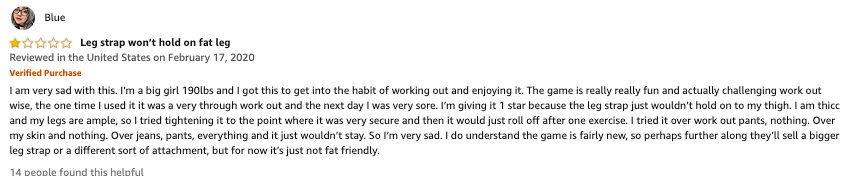

In [ ]:
test_review_1star = "I am very sad with this. I’m a big girl 190lbs and I got this to get into the habit of working out and enjoying it. The game is really really fun and actually challenging work out wise, the one time I used it it was a very through work out and the next day I was very sore. I’m giving it 1 star because the leg strap just wouldn’t hold on to my thigh. I am thicc and my legs are ample, so I tried tightening it to the point where it was very secure and then it would just roll off after one exercise. I tried it over work out pants, nothing. Over my skin and nothing. Over jeans, pants, everything and it just wouldn’t stay. So I’m very sad. I do understand the game is fairly new, so perhaps further along they’ll sell a bigger leg strap or a different sort of attachment, but for now it’s just not fat friendly."

print( 'Predicted rating', exp_pipeline.predict( [test_review_1star] ) )
print( 'Probabilities for all classes', exp_pipeline.predict_proba( [test_review_1star] ) )

In [ ]:
exp = explainer.explain_instance(test_review_1star, exp_pipeline.predict_proba, num_features=6, top_labels=2)
exp.show_in_notebook(text=True)

Our model made a prediction of score 1 <br>
* The model predicted overall rating of 2 with 20% probability from the training data <br> 
it learned to associate words such as 'cheaply', 'tile', 'fell', 'story' with 1-star <br>
reviews.
* The next class with the highest probability predicted by our model is 5 with 22% probability because <br>
our model learned to associate words such as 'art' and 'class' with 5-star reviews.

#### Predicting the overall score for a 3-star review from an unseen review/product [FIX THIS]

In [ ]:
test_review_3star = "it does a decent job at getting your heartrate up, but most of the workouts are ineffective at actually targetting the muscle groups they say they are targetting, everything effectively ends up becoming a chest/tricep workout if it involves the ringcon regardless of what the screen tells you. The 'core' or 'ab' workouts are a joke as squeezing the ringcon into your stomach does nothing for your abs. furthermore the motion sensors in the joycons are often either too sensitive or not sensitive enough for whatever activity you're trying to do, making it more frustrating to try to get through it, than enjoyable."

print( 'Predicted rating', exp_pipeline.predict( [test_review_3star] ) )
print( 'Probabilities for all classes', exp_pipeline.predict_proba( [test_review_3star] ) )

In [ ]:
exp = explainer.explain_instance(test_review_3star, exp_pipeline.predict_proba, num_features=8, top_labels=2)
exp.show_in_notebook(text=True)

Our model made the correct prediction of score 3 <br>
* The model predicted overall rating of 3 with 62% probability becuase from the training data <br> 
it learned to associate words such as 'small', 'uneven', 'meant', 'expected', 'magnets', 'actually', 'children' with 3-star <br>
reviews. The model also picked up some noise like 'Clancy', 'Cathy' and 'spies'.
* The next class with the highest probability predicted by our model is 2 with 26% probability because <br>
our model learned to associate words such as 'Depot', 'uneven', 'tile','tiles', 'underside' and 'stick' with 2-star reviews.

### Building a Theme-based recommender system with LDA (Latent Dirichlet Allocation) modelling

The purpose of this section is to use LDA topic modelling to identify various topics in all 5-star reviews <br>
and use them to build a theme based recommender system which given a particular user identifies topics in  <br>
all 5-star reviews given by that user and based on those topics finds other titles the user has not seen   <br>
for which the 5-star reviews given by other users contains similar topics and recommends them to that user. <br>
Steps in building the system : <br>
* Use Spacy and Gensim libraries to tokenize, lemmatize and clean all 5-star reviews and convert them to <br>
bag of word embeddings.
* Fit and LDA model on the word embeddings to identify 50 different topics 
* Use the fitted model to recommend titles to users based on the similar topics found in the titles they <br>
gave 5-star reviews and other title's 5-star reviews that they have not seen.

In [ ]:
#Importing all necessary modules 
import numpy as np
import os 
import codecs
import en_core_web_sm
from gensim.parsing.preprocessing import strip_non_alphanum, strip_numeric, strip_multiple_whitespaces, \
remove_stopwords, strip_short , split_alphanum, strip_punctuation
from gensim.models import Phrases
from gensim.models.phrases import Phraser 
from gensim.models.word2vec import LineSentence
import itertools as it 
nlp = en_core_web_sm.load()

In [ ]:
#Saving all 5-star review documents locally in a text file 
reviews_path = '/Users/anitatran/Desktop/amazon_review_project/reviews.txt'
np.savetxt( reviews_path, df.review_text[df.overall == 5].values, fmt = '%s'  )

In [ ]:
#Generator function that parses and yields each document in the text file  
def gen_line_review(filename):
    with codecs.open( filename, encoding = 'utf-8' ) as file:
        for review in file:
            review = split_alphanum(review)
            yield review
#Generator Function that parses each document in a file and tokenizes and lematizes using Spacy's pipeline and yields the tokenized document
def gen_lemmatized_corpus( filename ):
    for review in nlp.pipe( gen_line_review(filename), batch_size=10000, n_threads = 3 ):
        yield u' '.join( [ token.lemma_ for token in review if not( token.is_space or token.is_punct ) ] )

In [ ]:
#Reading each tokenized and lemmatized review document in unigram format and saving it a text file locally 
unigram_review_filepath = '/Users/anitatran/Desktop/amazon_review_project/unigram_reviews.txt'
with codecs.open(unigram_review_filepath, 'w', encoding = 'utf-8') as file:
    for review in gen_lemmatized_corpus( reviews_path ):
        file.write(review + '\n')
#Reading the file as a gensim object
unigram_reviews = LineSentence( unigram_review_filepath )

In [ ]:
for unigram_review in it.islice( unigram_reviews, 960,965 ):
    print( ' '.join(unigram_review) )
    print('')

All the tokens in each document are properly lemmatized and instead of lemmatizing pronouns, spacy simply replaces it with -PRON- which is of no <br>
consequence to us since we're only interested in the underlying topics.

#### Using gensim's bigram phraser to capture prevelant bigrams in our documents 

In [ ]:
#Function that takes in gensim pre-processing functions as arguements and applies them to a tokenized document 
#for clean up
def clean_up(text_list, **kargs):
    text = ' '.join(text_list)
    for func in kargs:
        text = kargs[func](text)
    return text.strip().split()

#Initializing the bigram phraser and it's wrapper 
bigram_model = Phrases(unigram_reviews)
bigram_phraser = Phraser(bigram_model)

bigram_review_filepath = '/Users/anitatran/Desktop/amazon_review_project/bigram_reviews.txt'
#Parsing each lemmatized document through a clean up function and then passing it through the bigram phraser and saving the results locally
with codecs.open(bigram_review_filepath, 'w', encoding='utf_8') as file:
    for unigram_review in unigram_reviews:
        unigram_review = clean_up( unigram_review, func1 = strip_non_alphanum, 
                                  func2 = strip_numeric, func3 = strip_multiple_whitespaces, func4 = strip_short )
        bigram_review = u' '.join( bigram_phraser[unigram_review] )   
        file.write(bigram_review + '\n')


bigram_reviews = LineSentence(bigram_review_filepath)

In [ ]:
for bigram_review in it.islice( bigram_reviews, 960,965 ):
    print( ' '.join(bigram_review) )
    print('')

The bigram phraser was able to capture certain bigrams such as 'release_date','single_player' in our lemmatized documents.

In [ ]:
#Further preprocessing the bigram embeddings by removing stopwords, extra space and an extremely prevalent noise word "quot"
preprocessed_reviews_filepath = '/Users/anitatran/Desktop/amazon_review_project/preprocessed_reviews.txt'
with codecs.open( preprocessed_reviews_filepath, 'w', encoding = 'utf-8' ) as file:
    for bigram_review in bigram_reviews:
        bigram_review = clean_up( bigram_review, func = remove_stopwords )
        preprocessed_review = u' '.join( [ word for word in bigram_review if not( word == 'PRON' or word == '\'s' or word =='quot' ) ] )
        file.write( preprocessed_review + '\n' )

In [ ]:
print('Raw Review Text:\n')
for review in it.islice( gen_line_review(reviews_path), 1554, 1555 ):
    print(review)
    
print('-----------\n')
print('Pre-processed:\n')

with codecs.open(preprocessed_reviews_filepath, encoding='utf_8') as file:
    for review in it.islice(file, 1554, 1555):
        print(review)   

Through the above functions and pipelines we were able to severly clean and  prune each review down to important key words ready for topic modelling like the example above. 

In [ ]:
!pip install pyLDAvis

In [ ]:
#Importing libraries for topic modelling 
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis, pyLDAvis.gensim
import warnings

In [ ]:
review_dict_filepath = '/Users/anitatran/Desktop/amazon_review_project/preprocessed_reviews_dict.txt'
preprocessed_reviews = LineSentence( preprocessed_reviews_filepath )
#Building the vocabulary from our reviews corpora to be used to convert each document to bag of words embedding 
review_dict = Dictionary( preprocessed_reviews )
#Filtering out extreme values from the corpora 
review_dict.filter_extremes( no_below = 15, no_above = 0.4 )
review_dict.compactify()
#Saving the dictionary locally 
review_dict.save( review_dict_filepath )

In [ ]:
#Generator function that parses a file containing documents and converts each document to a 
#bag of words embedding 
def generate_bow(file_path):
    for review in LineSentence(file_path):
        yield review_dict.doc2bow(review)

review_dict = Dictionary.load( review_dict_filepath )

reviews_bow_filepath = '/Users/anitatran/Desktop/amazon_review_project/reviews_bow.txt'

MmCorpus.serialize( reviews_bow_filepath, generate_bow( preprocessed_reviews_filepath ) )

In [ ]:
bow_corpus = MmCorpus(reviews_bow_filepath)

In [ ]:
#Fitting the LDA model on our bag of word embeddings 
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda = LdaMulticore( bow_corpus, num_topics = 50, id2word = review_dict, workers = 3 )

In [ ]:
#Visualizing each topic and it's most commonly occuring frequencies 
for idx, topic in lda.print_topics(-1):
    print('Topic: {} \nWords: {}\n'.format(idx, topic))

Some of the themes identified by our model are very easy to label such as topic 1 which contains frequencies such as "play","Mario", "kid" and is clearly about Mario/nostalgic games.

Topic 15 that contains frequencies like "multiplayer","Xbox","Halo","console" is clearly about console games.

Some topics such as topic 24 which contains frequencies such as "like","good","great","engine" it is not so clear what they are about.

#### Visualizing the topics and the distances between them using the pyLDAvis library

In [ ]:
LDAvis_prep = pyLDAvis.gensim.prepare( lda, bow_corpus, review_dict )
pyLDAvis.display( LDAvis_prep )

#### Building the recommender system 

In [ ]:
#Function that works as a pipeline in applying all the steps seen above to a raw review to convert it 
#to a clean bag of words embedding 
def _get_topics(review):
    
    spacy_tokenized_review = nlp( review )
    
    unigram_lemmatized_review = [  token.lemma_ for token in spacy_tokenized_review if not( token.is_space or token.is_punct ) ] 
    
    cleaned_lemmatized_unigram_review = clean_up( unigram_lemmatized_review, func1 = strip_non_alphanum, 
                                  func2 = strip_numeric, func3 = strip_multiple_whitespaces, func4 = strip_short )
    
    bigram_review =  bigram_phraser[cleaned_lemmatized_unigram_review]
    
    cleaned_bigram_review = clean_up( bigram_review, func = remove_stopwords )
    
    pre_processed_review = [ word for word in cleaned_bigram_review if not( word == 'PRON' or word == '\'s' or word =='quot' ) ]
    
    bow_review = review_dict.doc2bow(  pre_processed_review  )
    
    lda_review = sorted( lda[bow_review], key = lambda t: t[1], reverse = True)
    
    return lda_review

#Displays topics identified in a given review 
def display_topics(review, min_topic_freq = 0.1):
    for topic_num, freq in _get_topics(review):
        if freq < min_topic_freq:
            break
        print('Topic Number: {:<10} {:.3f}'.format( topic_num, freq ) )

In [ ]:
five_star_review_1 = df[ df.overall == 5 ].review_text[89456]
five_star_review_1

In [ ]:
display_topics(five_star_review_1)

In [ ]:
df.tail()

In [ ]:
five_star_review_2 = df[ df.overall == 5 ].review_text[23758]
five_star_review_2

In [ ]:
display_topics(five_star_review_2)

In [ ]:
from collections import Counter
#Function that pre-processed and extracts all the topics in a given raw review 
def _extract_topics(review):
    return [ t[0] for t in _get_topics(review) if t[1] > 0.1 ]
#Given a user, parses all the reviews given by that user and returns the 3 most prevalent topics in their reviews
def _get_user_topics(user_id):
    topics = []
    user_reviews = df[(df.reviewerID == user_id) & (df.overall == 5) ].review_text
    for review in user_reviews:
        topics.append( _extract_topics(review) )
    counter = Counter( [ topic_nums for inner_list in topics for topic_nums in inner_list ] )
    return [ t[0] for t in counter.most_common(3) ]
#Given a user returns a list of titles based on all the favorable reviews left by the user 
def recommend_titles(user_id):
    titles = []
    target_topics = _get_user_topics(user_id)
    print('Target Topics:' , target_topics)
    for index , row in df[ df.overall == 5 ].iterrows():
        topics = _extract_topics(row.review_text)
        for topic in topics:
            if topic in target_topics and row.title not in titles:
                titles.append( row.title )
    return titles     

In [ ]:
# sample user, takes a while !!
user = 'A3PX0TDUOI4OWS'
titles = recommend_titles(user)
print('Total games found:', len(titles))

In [ ]:
print('Titles rated highly by this user:\n')
print( df[ (df.overall == 5) & (df.reviewerID == user) ].title )

In [ ]:
print('Subset of games recommended by our LDA based recommender system:\n')
print(titles[264])
print(titles[161])
print(titles[6176])
print(titles[9156])

In [ ]:
df.head()

In [ ]:
df.head()

The theme based recommender system was succesfuly able to parse, pre-process , idetify themes and recommend titles <br>
based on favorable reviews given a user. However the model lacked certain finesse and fine tuning and also ended <br>
up being computationally ineffcient and would not be optimal to use when recommendations for multiple users <br>
have to be calculated and returned in real time. <br>
As a result a different approach altogether would be needed to build a more effcient recommender system that supports <br>
faster computation and more fine tuned results. To achieve that I will use a collaborative filtering based recommendation <br>
system using overall review scores in the next section.

### Collaborative Filtering Recommendation System with Matrix Factorization (SVD)
For this recommendation system we're not going to need the reviews but simply the overall ratings given by each user to <br>
different titles. I'm going to use a matrix where the rows are each unique title and the columns are each unique user and then <br>
apply singular value decomposition to reduce dimensionality by extracting the latent factors which would help us better model the<br>
similarity between users and items and create a recommendation system that is computationally efficient and faster once the matrix <br>
has been decomposed to it's latent space with n dimensions.<br>
This approach towards building a recommendation system is pretty popular and is called a model based Collabortaive filtering system.<br>
In layman's term the idea behind this model is that the preferences and attitudes of a user can be determined by a small number of <br>
factors and we'll decompose our utility matrix into these factors and then model the similarity between these titles based on the users <br>
who rated them and recommend them to other users with similar preferences.

In [6]:
df.head()

,Unnamed: 0,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,...,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,details
0,0,1.0,True,"06 9, 2014",A21ROB4YDOZA5P,0439381673,Mary M. Clark,I used to play this game years ago and loved i...,Did not like this,1402272000,...,NaN,by\n \n Learning Company,"['If you have not opened the item, you can ret...","['>#5,927 in Video Games (See Top 100 in Video...","['B00005LBVS', 'B002CMU748', 'B01JF4CHWK', 'B0...",Video Games,NaN,NaN,"\n\t\t\t\t\t\t\t\t\t\t\t\t<span class=""vertica...",NaN
1,1,3.0,True,"05 10, 2014",A3TNZ2Q5E7HTHD,0439381673,Sarabatya,The game itself worked great but the story lin...,Almost Perfect,1399680000,...,NaN,by\n \n Learning Company,"['If you have not opened the item, you can ret...","['>#5,927 in Video Games (See Top 100 in Video...","['B00005LBVS', 'B002CMU748', 'B01JF4CHWK', 'B0...",Video Games,NaN,NaN,"\n\t\t\t\t\t\t\t\t\t\t\t\t<span class=""vertica...",NaN
2,2,4.0,True,"02 7, 2014",A1OKRM3QFEATQO,0439381673,Amazon Customer,I had to learn the hard way after ordering thi...,DOES NOT WORK WITH MAC OS unless it is 10.3 or...,1391731200,...,NaN,by\n \n Learning Company,"['If you have not opened the item, you can ret...","['>#5,927 in Video Games (See Top 100 in Video...","['B00005LBVS', 'B002CMU748', 'B01JF4CHWK', 'B0...",Video Games,NaN,NaN,"\n\t\t\t\t\t\t\t\t\t\t\t\t<span class=""vertica...",NaN
3,3,1.0,True,"02 7, 2014",A2XO1JFCNEYV3T,0439381673,ColoradoPartyof5,The product description should state this clea...,does not work on Mac OSX,1391731200,...,NaN,by\n \n Learning Company,"['If you have not opened the item, you can ret...","['>#5,927 in Video Games (See Top 100 in Video...","['B00005LBVS', 'B002CMU748', 'B01JF4CHWK', 'B0...",Video Games,NaN,NaN,"\n\t\t\t\t\t\t\t\t\t\t\t\t<span class=""vertica...",NaN
4,4,4.0,True,"01 16, 2014",A19WLPIRHD15TH,0439381673,Karen Robinson,I would recommend this learning game for anyon...,Roughing it,1389830400,...,NaN,by\n \n Learning Company,"['If you have not opened the item, you can ret...","['>#5,927 in Video Games (See Top 100 in Video...","['B00005LBVS', 'B002CMU748', 'B01JF4CHWK', 'B0...",Video Games,NaN,NaN,"\n\t\t\t\t\t\t\t\t\t\t\t\t<span class=""vertica...",NaN


In [8]:
#Extracting the features needed to build the utility matrix 
user_rating_title_df = df[['reviewerID', 'title', 'overall']]

In [9]:
user_rating_title_df.head()

,reviewerID,title,overall
0,A21ROB4YDOZA5P,BRAND NEW Learning Company Oregon Trail 5th Ed...,1.0
1,A3TNZ2Q5E7HTHD,BRAND NEW Learning Company Oregon Trail 5th Ed...,3.0
2,A1OKRM3QFEATQO,BRAND NEW Learning Company Oregon Trail 5th Ed...,4.0
3,A2XO1JFCNEYV3T,BRAND NEW Learning Company Oregon Trail 5th Ed...,1.0
4,A19WLPIRHD15TH,BRAND NEW Learning Company Oregon Trail 5th Ed...,4.0


In [ ]:
print( 'Total unique video games in our dataset: {}'\
      .format( len(user_rating_title_df.title.unique() ) ) )

print('Total unique reviewers in our dataset: {}'\
     .format( len( user_rating_title_df.reviewerID.unique() ) ) )

print('Total reviews in our dataset: {}'.format( len(user_rating_title_df) ) )

Let's build our utility matrix

In [ ]:
# testing below 2020-10-14
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix

def create_csr_X_matrix(df):
    m_len = len(df.title.unique())
    u_len = len(df.reviewerID.unique())

    movie_encoder = LabelEncoder()
    user_encoder = LabelEncoder()

    m = movie_encoder.fit_transform(df.title)
    u = user_encoder.fit_transform(df.reviewerID)

    m_len = len(df.title.unique())
    u_len = len(df.reviewerID.unique())

    X = csr_matrix((df["overall"], (m, u)), shape=(m_len, u_len))
    return X, movie_encoder, user_encoder

In [ ]:
X, movie_encoder, user_encoder = create_csr_X_matrix(user_rating_title_df)

In [ ]:
from sklearn.neighbors import NearestNeighbors

movie = 'Soul Calibur II - Gamecube'

def find_me_a_game_to_play(movie_title, X, k=10):
    movie_ind = movie_encoder.transform([movie])
    movie_vec = X[movie_ind]
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric='minkowski')
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    close_movies = neighbour.flatten().tolist()
    z = [movie_encoder.inverse_transform([m])[0] for m in close_movies]
    z = [zi for zi in z if zi != movie_title]
    return z

In [ ]:
find_me_a_game_to_play('Just Dance 2 - Nintendo Wii', X, k=10)

In [ ]:
# delete - for testing
import pandas as pd
df = pd.read_csv('video_games_reviews.csv')

In [2]:
#Extracting the features needed to build the utility matrix 
user_rating_title_df = df[['reviewerID', 'title', 'overall']]

Pivoting the extracted dataframe to build the utility matrix and transposing it to get shape we want 

In [32]:
# taking the first x rows
user_rating_title_df_1 = user_rating_title_df.head(500000)

In [6]:
user_rating_title_df_1.shape

(900000, 3)

In [ ]:
user_rating_title_df_1.shape()

Original code below

In [ ]:
utility_matrix = user_rating_title_df_1.pivot_table(values = 'overall', columns = 'title', index = 'reviewerID' , fill_value = 0)


In [ ]:
utility_matrix = utility_matrix.T
utility_matrix.head()

In [ ]:
from sklearn.decomposition import TruncatedSVD
#Initializing the svd class to decompose our utility matrix to 10000 most important latent factors 
svd = TruncatedSVD(n_components = 10000, random_state = 42)
#Fitting it on our data
t_matrix = svd.fit_transform( utility_matrix )
#Calculating the correlation matrix of our decomposed matrix 
corr_mat = np.corrcoef( t_matrix )

In [ ]:
#Saving the decomposed and correlation matrix to file 
corr_svd_mat_filepath = '/Users/sam/DataScience/Datasets/corr_svd_mat_reviews'
np.save( corr_svd_mat_filepath, corr_mat )
svd_mat_filepath = '/Users/sam/DataScience/Datasets/svd_mat_reviews'
np.save( svd_mat_filepath, t_matrix )

In [ ]:
movie_names =  utility_matrix.T.columns 
movie_names_list = list( movie_names )
#Function that takes in a user id and returns a list containing the top 5 recommendations for each movie
#the user rated 5 stars based on the calculated corr matrix 
def recommend_titles_cf(user_id):
    
    recommended = []
    user_movies = set( data[ (data.reviewerID == user) & (data.overall == 5) ].title )
    
    for w_title in user_movies:
        w_title_high_corr_indices =  np.argsort( corr_mat[ movie_names_list.index(w_title) ] )
        
        for title_index in w_title_high_corr_indices[::-1][1:6]:
            if movie_names[title_index] not in recommended:
                recommended.append( movie_names[title_index] )
    
    return recommended 

In [ ]:
print('Titles rated highly by this user:\n')
for movie in list( ( data[ (data.overall == 5) & (data.reviewerID == user) ].title ) ):
        print(movie)
print()
print()
print()
print('Titles recommneded by our collaborative filtering system:\n')
for movie in recommend_titles_cf('A3QOPWF1LQCR6L'):
    print(movie)

* The user rated 'Air Force One' highly which is an action/thriller/spy movie  and we see the model recommended other such <br>
movies such as 'The Bone Collector', 'The Bourne Identity', 'Training Day' and another famous Harrison Ford movie 'The Patriot Games' 
* The user rated 'Black Hawk Down' highly which is a war/action movie and we see the model recommended other such movies <br>
like 'Pearl Harbor' and 'Saving Private Ryan'.
* The user rated 'One Fine Morning' and 'You've Got Mail' which are drama movies and we see the model recommended other such movies <br>
such as 'Sleepless in Seattle', 'While you were sleeping', 'French Kiss'. 

<br>For a very simple collaborative filtering system out model has done a good job of recommending movies to the given user.

5. Discussion
5.1 Further Improvements
Businesses do not necessarily need to have a sentiment score for reviews, especially for ecommerce sites such as Amazon where a rating is also available. For manufactures in particular even if they have a score they would not know exactly where to prioritize their efforts to improve their products. Instead, by giving them the specifics characteristics where their products are failing or not they get valuable insights to tackle problems as they arise. Hence, the challenge of correctly extracting the products characteristics is of major importance. This application underperforms in the capabilities of extracting the characteristics and seems to perform fairly well in assigning the correct sentiments to them (although some exceptions need to be adjusted through gazetteers by using the domain knowledge of the business and industry). To further improve characteristics extraction an approach using topic modelling could be implemented, where assumptions are made on the probabilistic distribution of topics inside documents. An example of this would be the Latent Dirichlet Allocation that outputs word clusters. By extending the basic model of identifying topics, we can separate sentiment and features from each topic. As mentioned before, opinion word can be incorrectly assigned to characteristics when multiple characteristics are present, a task that could be tackled and improved with the usage of Name Entity Recognition (NER) and Relationship extraction (RE). Because of computational limitations we worked only on a subsample of the ~400,000 reviews. In the future using cloud computing as well as parallelization and improving the algorithm will allow to process an even larger amount of reviews. Finally to have statistically significant results a larger test set should be created with roughly at least 10% of the data (for this project only ~150 reviews were created).

5.2 Conclusion
In this project we analyzed the performance of measuring sentiment analysis on specific characteristics of mobile phones mentioned in customer reviews to provide manufacturers with actionable insights to improve their products and for sellers to improve their offerings. Results shows the worst performance on characteristic extraction where Recall is critically low. This topic is also the main challenge which could be further improved by implementing topic modelling. Sentiment scores on characteristics extraction revealed a good but not great performance suggesting that further improvements could be made using Relationship Extraction. However the test set was too small to have a clear statistical significance on the results.

In [ ]:
#  

### DISREGARD BELOW THIS / TESTING

In [ ]:
%%html
<style>
table,td,tr,th {border:none !important; }
</style>

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 

About the data:
- number of ratings are evenly distributed from 1-5
- a wealth of information on the review text!
- but how to process them? what does this mean about the data?

<a id='unsupervised'></a>

## Unsupervised learning

---

> **Supervised --> Classification** - create a model to predict which group a point belongs to.

> **Unsupervised --> Clustering** - find groups that exist in the data already.

We use unsupervised methods when we don't have labeled  data. There are no true targets to predict, we derive the likely categories from the structure in our data.

| Pros | Cons |
|---|---|
| No labels | Difficult to evaluate correctness without subject matter expertise |
| Few or no assumptions about data | Scaling / normalization often required |
| Useful for subset / segmentation discovery | Can be difficult to visualize |
| Great for broad insights | Extremely difficult to tune |
| Many models avalable | No obvious choice in many cases |
| Black magic | Considered "unconventional" and unreliable |

In [ ]:
import pandas as pd
import numpy as np
import re

import bz2

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.metrics import f1_score,roc_auc_score, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
col_names = ['rating','title','review']
df = pd.read_csv('train.csv', names=col_names)

df.info()

In [ ]:
# ratings from the raw data is evenly distributed
df.hist()

In [ ]:
# the percentage of missing data in each column
df.isnull().sum() / len(df)


In [ ]:
# 08/21 goal is to do sentiment analysis on reviews to see if it matches with ratings
# might change goal later on

# replace the rating: 3 and above as 1 and below 3 as 0.
def filter_data(value):
    if value>=3.0:
        return 1
    else:
        return 0
#creating a new column has the filtered data
df['modified'] = df['rating'].apply(filter_data)

In [ ]:
df = df.dropna()

In [ ]:
# random sample 10000 for easier computation, rather than 3M entries
df = df.sample(10000)

In [ ]:
"""
in the statement ==> df.reset_index(drop=True,inplace=True)
what we actually do is we reset the index number in the dataset because
if we don't do it the column numbers will be disordered.
if we don't do we will have index number like 0,1,2,3,7,10,11,17.
if we have like this iteration is not possible we will get key value error
"""
df.reset_index(drop=True,inplace=True)

In [ ]:
# let's take a look at our data
df.info()

In [ ]:
df.head()

In [ ]:
nltk.download('stopwords')

In [ ]:
 # Search through regex for the special character set, using the substitute function substitute the regex with space using this [^a-zA-Z ] which finds those which do not belong to a to z or A to Z. Then I made the sentence to lower case and then split it into words then I had to check whether the word belongs to the stopwords or not for this I used the porter stemmer class to perform it.
corpus = []
for i in range(0, 10000):
    review = re.sub('[^a-zA-Z]', ' ', df['review'][i])
    review = review.lower()
    review = review.split()
    review = [word for word in review if not word in set(stopwords.words('english'))]
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
# vectorization
# convert textual data to numerical format. Using vectorization, a matrix is created where each column represents a feature and each row represents an individual review.

# Creating the Bag of Words model using CountVectorizer
cv = CountVectorizer(max_features = 1500)
features = cv.fit_transform(corpus).toarray()
labels = df.iloc[:, -1].values

In [ ]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3, random_state = 42)

In [ ]:
# multinomial NB
# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix:\n",cm)

# Accuracy, Precision and Recall
score1 = accuracy_score(y_test,y_pred)
score2 = precision_score(y_test,y_pred)
score3= recall_score(y_test,y_pred)
print("\n")
print("Accuracy is ",round(score1*100,2),"%")
print("Precision is ",round(score2,2))
print("Recall is ",round(score3,2))

In [ ]:
# Bernoulli NB

# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import BernoulliNB
classifier = BernoulliNB(alpha=0.8)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix:\n",cm)

# Accuracy, Precision and Recall

score1 = accuracy_score(y_test,y_pred)
score2 = precision_score(y_test,y_pred)
score3= recall_score(y_test,y_pred)
print("\n")
print("Accuracy is ",round(score1*100,2),"%")
print("Precision is ",round(score2,2))
print("Recall is ",round(score3,2))

In [ ]:
# Logistic Regression

# Fitting Logistic Regression to the Training set
from sklearn import linear_model
classifier = linear_model.LogisticRegression(C=1.5)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix:\n",cm)

# Accuracy, Precision and Recall

score1 = accuracy_score(y_test,y_pred)
score2 = precision_score(y_test,y_pred)
score3= recall_score(y_test,y_pred)
print("\n")
print("Accuracy is ",round(score1*100,2),"%")
print("Precision is ",round(score2,2))
print("Recall is ",round(score3,2))
